In [60]:
## Set up dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

df = pd.read_csv("base_dataset.csv")

In [61]:
## Clean up data

import re

df = df[df['viewCount'].notna()]
# df = df[df['likeCount'].notna()]
# df = df[df['commentCount'].notna()]

# Titles
def process_title(title):
    title = str(title)
    # title = re.sub(r"&.*?;", " ", title)
    title = re.sub(r"[!\"#\＄%&\(\)\*\+,-\./:;<=>\?@\[\\\]\^_`{\|}~]", " ", title)
    title = title.lower()
    title = title.split(" ")
    title = list(filter(None, title))
    return title

titles = df["vidTitle"].map(process_title)

# Tags
def process_tags(tags):
    if(tags == None):
        return []
    tags = str(tags)
    tags = tags.lower()
    tags = tags[1:-1]
    tags = tags.split(", ")
    tags = [tag[1:-1] for tag in tags]
    tags = list(filter(None, tags))
    return tags

tags = df["tags"].map(process_tags)
df["tagCount"] = len(tags)

# Times
df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='%Y-%m-%dT%H:%M:%SZ')

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,publishedAt,categoryId,channelId,channelTitle,vidTitle,tags,viewCount,likeCount,commentCount,thumbnail hq,thumbnail mq,thumbnail lq,videoId,tagCount
0,2018-12-24 16:53:47,28,UCRP4EhX1Op-jL7D87PB3qhQ,808,Ночь в КИТАЙСКОМ плацкарте 2019 года,"['плацкарт', 'китай', 'китайский плацкарт', 'в...",19940416.0,347146.0,17548.0,https://i.ytimg.com/vi/4OX1h3rr3YY/hqdefault.jpg,https://i.ytimg.com/vi/4OX1h3rr3YY/mqdefault.jpg,https://i.ytimg.com/vi/4OX1h3rr3YY/default.jpg,4OX1h3rr3YY,920
1,2020-10-11 05:30:00,10,UCwAdbVxjUiDVDsW_f4gLzgQ,V BoY,Mama Aya Rap Song- V boY | Diss to Papa Hai😈 |...,"['Mama aya rap song', 'papa hai rap song', 'pa...",13660426.0,153395.0,2272.0,https://i.ytimg.com/vi/AWHeVmD06Dw/hqdefault.jpg,https://i.ytimg.com/vi/AWHeVmD06Dw/mqdefault.jpg,https://i.ytimg.com/vi/AWHeVmD06Dw/default.jpg,AWHeVmD06Dw,920
2,2018-02-01 15:53:14,24,UCBMeo8x6iFI23jjWwUT-7Uw,Celine Tam Official,You Raise Me Up Celine Tam 譚芷昀 Miss World 2017...,"['celinetam', 'dion tam', 'stevetam', 'funny v...",9356919.0,105209.0,198.0,https://i.ytimg.com/vi/P4OM7Zsrfb4/hqdefault.jpg,https://i.ytimg.com/vi/P4OM7Zsrfb4/mqdefault.jpg,https://i.ytimg.com/vi/P4OM7Zsrfb4/default.jpg,P4OM7Zsrfb4,920
3,2020-06-01 17:30:02,10,UCD0WysHED1NfXUk3vedtRhQ,Islamic Releases,"Relaxing Sleep, ALLAH HU, Listen &amp; Feel Re...","['ALLAH HU', 'Listen & Feel Relax', 'Best for ...",9255488.0,162443.0,6553.0,https://i.ytimg.com/vi/duJT2-51l98/hqdefault.jpg,https://i.ytimg.com/vi/duJT2-51l98/mqdefault.jpg,https://i.ytimg.com/vi/duJT2-51l98/default.jpg,duJT2-51l98,920
4,2021-12-29 16:00:04,24,UCJ9tHJbCa8ZoMbapfJLy0ZQ,imineo Documentaires,"Chine, l&#39;autoroute du vertige","['reportage', 'documentaire', 'chine', 'autoro...",8062716.0,32146.0,1425.0,https://i.ytimg.com/vi/9e58oyeOPX8/hqdefault.jpg,https://i.ytimg.com/vi/9e58oyeOPX8/mqdefault.jpg,https://i.ytimg.com/vi/9e58oyeOPX8/default.jpg,9e58oyeOPX8,920


In [46]:
## Train Model for Word2Vec

from gensim.models import Word2Vec, FastText

def convertToVec(w2v, wordlist):
    if (len(wordlist) == 0):
        return np.zeros(w2v.vector_size)
    else:
        return np.mean([w2v.wv[word] if (word in w2v.wv) else np.zeros(w2v.vector_size) for word in wordlist], axis=0)

vector_size_titles = 300
w2v_titles = Word2Vec(titles, min_count=2, vector_size = vector_size_titles)
title_vectors = [convertToVec(w2v_titles, title) for title in titles]
title_vec_cols = ["titleVec" + str(num) for num in range(vector_size_titles)]
title_vec_df = pd.DataFrame(title_vectors, index=df.index, columns = title_vec_cols)
df = pd.concat([df, title_vec_df], axis=1)

vector_size_tags = 300
w2v_tags = Word2Vec(tags, min_count=2, vector_size = vector_size_tags)
tags_vectors = [convertToVec(w2v_tags, tagList) for tagList in tags]
tags_vec_cols = ["tagsVec" + str(num) for num in range(vector_size_tags)]
tags_vec_df = pd.DataFrame(tags_vectors, index=df.index, columns = tags_vec_cols)
df = pd.concat([df, tags_vec_df], axis=1)

MAE: 34107052.00679348
RMSE: 108255934.05046275


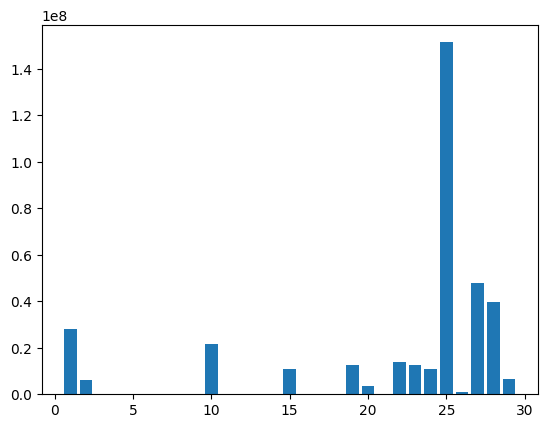

In [49]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

x_labels = ["categoryId", "tagCount"] + title_vec_cols + tags_vec_cols
y_labels = ["viewCount"]
x = df.loc[:, x_labels]
y = df.loc[:, y_labels]
dmatrix = xgb.DMatrix(data=x,label=y)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',
                           colsample_bytree = 0.3, 
                           learning_rate = 0.1,
                           max_depth = 10, 
                           alpha = 50, 
                           n_estimators = 10)

xgb_reg.fit(x_train, y_train)
pred = xgb_reg.predict(x_test)

# cats = list(range(1, np.array(df["categoryId"]).max()+1))
# catv = []
# for cat in cats:
#     catv.append(np.mean(df[df.categoryId == cat]["viewCount"]))
# plt.bar(cats, catv)

print("MAE: " + str(mean_absolute_error(y_test, pred)))
print("RMSE: " + str(np.sqrt(mean_squared_error(y_test, pred))))

In [7]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.3,
                'max_depth': 10, 'alpha': 10}

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3,
                    num_boost_round=100,early_stopping_rounds=20,metrics="rmse", as_pandas=True, seed=123)

cv_results.describe()
print(cv_results)

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0        91.090988        3.732703       91.093904       8.681391
1        88.495440        3.338890       88.832230       8.356700
2        87.147969        3.127699       87.795114       7.890722
3        86.452434        3.021541       87.354288       7.429542
4        86.097054        2.965904       87.193656       7.037225
5        85.914080        2.936251       87.152253       6.720735
